# Object Detection in videos

In this session we will test a pretrained SSD model on video frames.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
import numpy as np

In [2]:
#to display videos
import io
import base64
from IPython.display import HTML

Let's define the PASCAL VOC classes to be detected. Here we also set the image dimensions for the network's input, which will be 300x300:

In [3]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1
w,h,c = (300,300,3)
input_shape=(w, h, c)

Load the weights of the pretrained model:

In [5]:
from ssd import SSD300

weights_dir = '../../../../data/weights_SSD300.hdf5'
model = SSD300(input_shape, num_classes=NUM_CLASSES,weights=weights_dir)

Let's first play the video we picked:

In [6]:
file_name = '../data/vids/bikes.mp4'
video = io.open(file_name, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii')))

Here we load the video and set the number of frames we want to use. These will be uniformly sampled from the video.

In [8]:
import imageio
imageio.plugins.ffmpeg.download()
vid = imageio.get_reader(file_name,  'ffmpeg')

# Sample N frames from video
sample_frames = 40
vid_frames = vid.get_length()
print ("Number of frames",vid_frames)
sample = int(np.ceil(float(vid_frames) / sample_frames))
idxs = range(0,vid_frames,sample)

ims = []
for idx in idxs:
    ims.append(vid.get_data(idx))

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0%)1949696/28549024 bytes (6.8%)4956160/28549024 bytes (17.4%)7987200/28549024 bytes (28.0%)10993664/28549024 bytes (38.5%)14024704/28549024 bytes (49.1%)17047552/28549024 bytes (59.7%)20045824/28549024 bytes (70.2%)23068672/28549024 bytes (80.8%)26099712/28549024 bytes (91.4%)28549024/28549024 bytes (100.0%)
  Done
File saved as /home/deeplearner/.imageio/ffmpeg/ffmpeg.linux64.
('Number of frames', 151)


Now we are ready to test the model on some images. Here we load and preprocess them to be fed into the network:

In [9]:
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from scipy.misc import imresize

def preproc_frames(ims,target_size):
    ims_input = []
    for im in ims:
        im = imresize(im,target_size)
        ims_input.append(image.img_to_array(im))
    return ims_input

inputs = preproc_frames(ims,(w,h))
inputs = preprocess_input(np.array(inputs))

Forward pass:

In [10]:
preds = model.predict(inputs, batch_size=1, verbose=2)

Let's define a function ```display_boxes``` to plot all the predicted boxes into the image:

In [11]:
def display_boxes(img,preds,score_thresh,display=0):
    
    det_label = preds[:, 0]
    det_conf = preds[:, 1]
    det_xmin = preds[:, 2]
    det_ymin = preds[:, 3]
    det_xmax = preds[:, 4]
    det_ymax = preds[:, 5]
    
    # Get detections with confidence higher than th
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= score_thresh]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    fig = plt.figure()
    plot = fig.add_subplot(111)
    
    plot.imshow(img / 255.)
    plot.axis('off')
    currentAxis = fig.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

    if display:
        plt.show()
    else:
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return data


In this step we already have the predictions of the network for our picked images. Some of the detected boxes will be discarded in this step, if their overlap with higher scoring boxes is greater than ```nms_thresh```:

In [12]:
from ssd_utils import BBoxUtility
nms_thresh = 0.4
bbox_util = BBoxUtility(NUM_CLASSES,nms_thresh = nms_thresh)
results = bbox_util.detection_out(preds)

Here we display the remaining boxes after NMS (for the first frame):

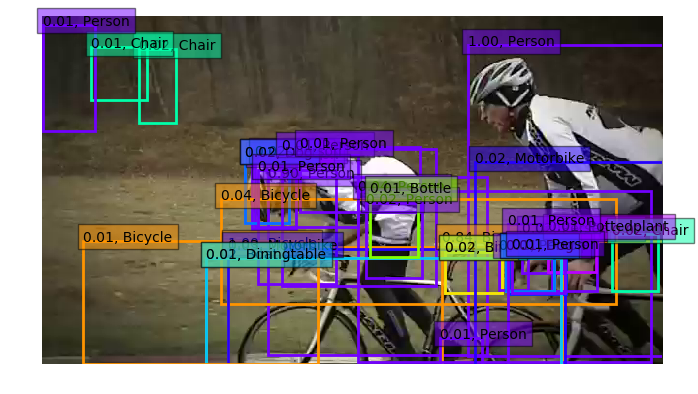

In [13]:
display_boxes(ims[0],results[0],0,1)

At this point we filtered out high overlapping boxes, now let's pick the ones we want to display based on their detection confidence. Here we set a score threshold ```score_thresh``` of 0.6, and we only keep boxes with a higher score.

In [14]:
# min detection confidence to display
score_thresh = 0.6
out_ims = []
for i, img in enumerate(ims):
    out_ims.append(display_boxes(img,results[i],score_thresh,0))

Create a video from the detections to display:

In [15]:
file_name = '../data/out/out_vid.mp4'
imageio.mimwrite(file_name,out_ims)

In [16]:
video = io.open(file_name, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii')))

**Exercise:** Are these good results? We can see that the detector missed some objects. You can play with the different parameters that we fixed (e.g. ```nms_thresh```, ```score_thresh```) and see how they affect the results. You can also find more videos in the same folder that you can test the network on.

### Towards object tracking:

**Exercise:** At this point, there is no association between the instances in different frames. Although this will be solved in the next lab session, if you are feeling adventurous, you can come up with a simple heuristic based on the intersection over union between detections in different frames. Below you can find a function to compute the intersection over union between two boxes.

**Exercise:** Detections between frames are also not smooth. The size and position of two detections of the same object in different frames can change quite a lot. Can you think of any simple heuristic you could implement to smooth detections? Maybe computing new box coordinates by weighting the ones in the current and previous frames.

In [17]:
def bb_intersection_over_union(boxA, boxB):
    # boxes should be in the form [x1,y1,x2,y2]
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou